# 전처리 / 모델 적용 튜토리얼

작성자: 심소연

작성일: 2022-03-30

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn')
sns.set(font_scale=1.25)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# 3. Feature engineering

## 3.1 Fill NULL - Embarked, Age

In [4]:
(df_train.isnull().sum() / df_train.shape[0] * 100).to_frame('% of NULL').transpose()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
% of NULL,0.0,0.0,0.0,0.0,0.0,19.86532,0.0,0.0,0.0,0.0,77.104377,0.224467


In [5]:
(df_test.isnull().sum() / df_test.shape[0] * 100).to_frame('% of NULL').transpose()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
% of NULL,0.0,0.0,0.0,0.0,20.574163,0.0,0.0,0.0,0.239234,78.229665,0.0


In [6]:
# Fare

# loc
# https://m.blog.naver.com/wideeyed/221964700554
# ,로 행과 열을 구분한다

df_test.loc[df_test['Fare'].isnull(), 'Fare'] = df_test['Fare'].mean()

In [7]:
# Embarked

df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
df_train['Embarked'].fillna('S', inplace = True)

In [9]:
# Age

# (1) dtype 을 string 으로 변경하여
# (2) 정규표현식을 이용하여 이름 (문자열) 으로부터 Title 을 추출하고자 한다.

# 사용된 정규 표현식 기호
# - 범위
# [] 문자 선택
# + 한 번 이상 반복됨

df_train['Title'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Title'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [10]:
original_title = [
    'Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col',
    'Rev', 'Capt', 'Sir', 'Don', 'Dona'
]

In [11]:
group_title = [
    'Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other',
    'Other', 'Mr', 'Mr', 'Mr', 'Mr'
]

In [12]:
# (1) 탑승객을 성별보다 다양한 분류로 나누어서 
# (2) 분류된 집합에서의 나이의 평균값을 이용하여 
# (3) 채워지지 않은 나이에 대한 값을 채우고자 한다.

df_train['Title'].replace(original_title, group_title, inplace=True)
df_test['Title'].replace(original_title, group_title, inplace=True)

<AxesSubplot:xlabel='Title'>

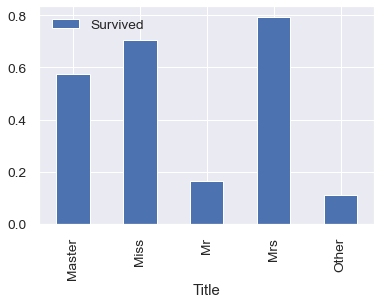

In [13]:
# 유의미한 생존율 차이가 보임을 확인할 수 있다.

df_train[['Title', 'Survived']].groupby('Title').mean().plot.bar()

In [14]:
df_train.groupby('Title').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Title,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,34.703125
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,43.937188
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,24.939822
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,45.420603
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,19.102778


In [15]:
tmp = df_train.groupby('Title').mean()
for title in tmp.index:
    df_train.loc[(df_train.Age.isnull()) & (df_train.Title == title),
                 'Age'] = round(tmp.loc[title].Age)
    df_test.loc[(df_test.Age.isnull()) & (df_test.Title == title),
                'Age'] = round(tmp.loc[title].Age)

## 3.2 Change Age (continuous to categorical)

In [16]:
df_train['Age_cat'] = 0
df_test['Age_cat'] = 0

In [17]:
for i in range(8):
    df_train.loc[(df_train.Age >= (i * 10)) & (df_train.Age < (i + 1) * 10),
                 'Age_cat'] = i
    df_test.loc[(df_test.Age >= (i * 10)) & (df_test.Age < (i + 1) * 10),
                'Age_cat'] = i
df_train.loc[df_train.Age >= 80, 'Age_cat'] = 7
df_test.loc[df_test.Age >= 80, 'Age_cat'] = 7

In [18]:
df_train.drop(['Age'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3 Change Title, Embarked, Sex (string to numerical)

In [19]:
# Title
df_train['Title'] = df_train['Title'].map({
    'Master': 0,
    'Miss': 1,
    'Mr': 2,
    'Mrs': 3,
    'Other': 4
})

df_test['Title'] = df_test['Title'].map({
    'Master': 0,
    'Miss': 1,
    'Mr': 2,
    'Mrs': 3,
    'Other': 4
})

In [20]:
# Embarked
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [21]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [22]:
# Sex
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

## 3.4 Fare, Cabin, FamilySize

In [23]:
# Cabin
df_train.drop(['Cabin'], axis=1, inplace=True)
df_test.drop(['Cabin'], axis=1, inplace=True)

In [24]:
# Fare
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

df_test.loc[df_test['Fare'].isnull(), 'Fare'] = df_test['Fare'].mean()

In [25]:
# FamilySize
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

## 3.5 One-hot encoding
순서가 없는 카테고리형 변수

In [26]:
df_train.drop(['Name', 'PassengerId', 'SibSp', 'Parch'], axis=1, inplace=True)
df_test.drop(['Name', 'PassengerId', 'SibSp', 'Parch'], axis=1, inplace=True)

In [27]:
df_train.head(1)

,Survived,Pclass,Sex,Ticket,Fare,Embarked,Title,Age_cat,FamilySize
0,0,3,1,A/5 21171,1.981001,2,2,2,2


In [28]:
# Title
df_train = pd.get_dummies(df_train, columns=['Title'], prefix='Title')
df_test = pd.get_dummies(df_test, columns=['Title'], prefix='Title')

# Embarked
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

## 3.5.1 Ticket

In [29]:
# Ticket 있는 버전은 _ticket 추가함
df_train_ticket = df_train
df_test_ticket = df_test

In [30]:
df_train_ticket['TicketFirstNum'] = df_train_ticket['Ticket'].map(
    lambda i: str(i)[0:1] if i.isdigit() else '0')
df_test_ticket['TicketFirstNum'] = df_test_ticket['Ticket'].map(
    lambda i: str(i)[0:1] if i.isdigit() else '0')

In [31]:
df_train_ticket['Ticket'] = df_train_ticket['TicketFirstNum']
df_test_ticket['Ticket'] = df_test_ticket['TicketFirstNum']

df_train_ticket.drop(['TicketFirstNum'], axis=1, inplace=True)
df_test_ticket.drop(['TicketFirstNum'], axis=1, inplace=True)

In [32]:
df_train_ticket['Ticket'] = df_train_ticket['Ticket'].astype(int)
df_test_ticket['Ticket'] = df_test_ticket['Ticket'].astype(int)

In [33]:
# Ticket 없는 버전이 기본
# inplace 속성 없앰
df_train = df_train.drop(['Ticket'], axis=1)
df_test = df_test.drop(['Ticket'], axis=1)

In [34]:
# Ticket
df_train_ticket = pd.get_dummies(df_train_ticket, columns=['Ticket'], prefix='Ticket')
df_test_ticket = pd.get_dummies(df_test_ticket, columns=['Ticket'], prefix='Ticket')

In [35]:
# Ticket 의 경우 빈 값도 많아 이 방법을 사용했을 때, 열 개수가 일치하지 않는 문제점 발생
difference = set(df_train_ticket.columns) - set(df_test_ticket.columns) - {'Survived'}

In [36]:
for col in difference:
    df_test_ticket[col] = 0

# 4. Building machine learning model and prediction

In [37]:
from sklearn.ensemble import RandomForestClassifier # random forest 를 이용한 classifier
from sklearn import metrics # 모델의 평가를 위함
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수

In [38]:
# 4.1. preparation
# split dataset int train, valid, test

# training set 에서 target label 을 분리
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

# train set 으로부터 valid set 을 따로 남겨둠
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train,
                                            target_label,
                                            test_size=0.3,
                                            random_state=2018)

In [39]:
# 4.2. model genration and prediction
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [40]:
# accuracy (이 때 valid set 이용)
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(
    y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 83.21% 정확도로 생존을 맞춤


In [41]:
# 4.3. feature importance

from pandas import Series

In [42]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

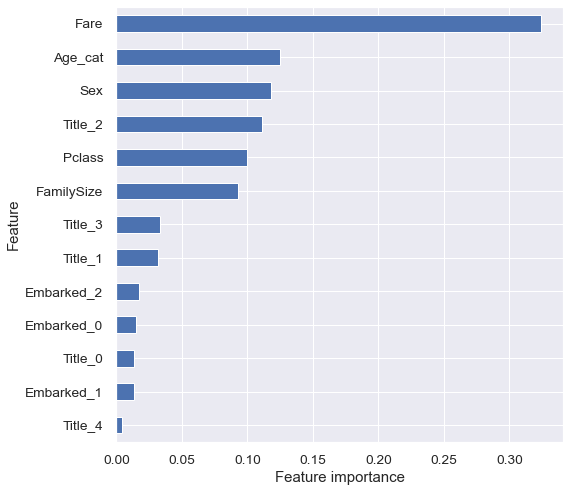

In [43]:
# Ticket 고려하지 않은 경우
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [44]:
# 4.4. prediction on test set

prediction = model.predict(X_test)
df_test['Survived'] = prediction

In [59]:
# Ticket 고려한 경우

X_train = df_train_ticket.drop('Survived', axis=1).values
target_label = df_train_ticket['Survived'].values
X_test = df_test_ticket.values

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train,
                                            target_label,
                                            test_size=0.3,
                                            random_state=2018)

model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(
    y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 84.33% 정확도로 생존을 맞춤


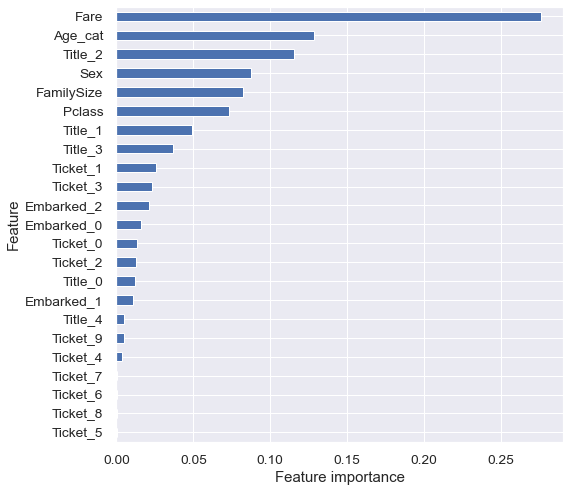

In [60]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test_ticket.columns)

plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()